# Ellipse calculations

## Imports

In [1]:
# Python standard library
import sys
import csv


# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.interpolate
#import seaborn as sns


# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Constants

In [2]:
save_data = True
save_plot = True

nm = 10**(-9.)
um = 10**(-6.)

## Load video and events

In [3]:
date = '10-10-2017'
particle = '293-T_0'
channel = '10-20-10_1'
file_index = '0'

base_path = oi_file.data_base_path

oi_vid_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/events/test_camera_' + file_index + '_events.json'


res_x = 384
res_y = 112
fps = 250000.
exposure_time = .5*10**(-6.)

In [4]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

## Output

In [5]:
save_base_path = oi_file.ellipse_base_path + date + '/' + particle + '/' + channel + '/' + file_index

print save_base_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/293-T_0/10-20-10_1/0


# Create stage

[ 0.03263567  0.99946731]


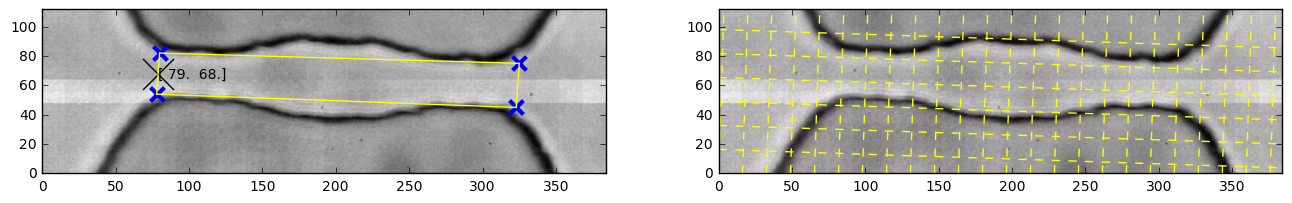

In [6]:
reload(oi)
template_index = 100
template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + '/' + date + '/' + particle + '/' + channel + '/oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)

c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Load ellipses

In [7]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + '/' + date + '/' + particle + '/' + channel + '/' + file_index + '/ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

## Filter

In [8]:
# Load keep indices
filter_file_path = '../data/' + date + '/' + particle + '/' + channel + '/' + file_index + '/filter'
with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]
            




# Manual filter
manual_filter_file_path = filter_file_path.replace('filter', 'manual_filter')
manual_remove_indices = []
with open(manual_filter_file_path, 'r') as manual_filter_file_handle:
    reader = csv.reader(manual_filter_file_handle)
    for row in reader:
        manual_remove_indices.append(int(row[0]))
        
keep_indices = [keep_index for keep_index in keep_indices if keep_index not in manual_remove_indices]
    
    
print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

oi_events = filtered_oi_events
ellipsess = filtered_ellipsess

loaded keep indices ( 318 events total):
[2, 5, 6, 16, 18, 21, 23, 24, 33, 36, 43, 44, 48, 49, 50, 52, 53, 54, 59, 60, 62, 63, 72, 75, 78, 81, 84, 90, 91, 95, 96, 101, 104, 113, 116, 122, 123, 130, 138, 143, 149, 150, 151, 156, 159, 160, 164, 170, 173, 182, 183, 185, 187, 189, 194, 196, 197, 200, 202, 203, 208, 209, 210, 212, 215, 216, 217, 219, 221, 222, 230, 231, 240, 241, 248, 258, 259, 261, 265, 267, 268, 269, 270, 274, 275, 280, 282, 287, 295, 298, 299, 310, 313, 315, 316, 317, 325, 327, 328, 331, 334, 360, 361, 362, 367, 369, 370, 376, 383, 390, 392, 399, 401, 414, 417, 419, 420, 422, 431, 437, 438, 441, 445, 446, 454, 455, 456, 464, 468, 474, 487, 492, 493, 500, 503, 507, 511, 518, 519, 526, 527, 532, 536, 540, 545, 546, 547, 557, 559, 563, 568, 570, 576, 577, 581, 583, 591, 594, 596, 599, 600, 603, 604, 606, 609, 610, 618, 622, 625, 626, 627, 633, 638, 639, 644, 648, 649, 650, 652, 655, 657, 664, 667, 673, 675, 680, 681, 682, 691, 693, 697, 706, 707, 709, 711, 715, 718, 732, 73

## Calculations

In [10]:
features = ['event_num', 'ellipse_num', 'tf', 'x_pix', 'xc_pix', 'xc_um', 'y_pix', 'yc_pix', 'yc_um', 'a_pix', 'a_um', 'b_pix', 'b_um', 'r_pix', 'r_um', 'aspect-ratio', 'theta_rad', 'speed_pix/frame', 'speed_m/s']
output_file_path = save_base_path + '/calculations'

with open(output_file_path, 'w') as output_file_handle:
    output_writer = csv.writer(output_file_handle, delimiter = ',')

    output_writer.writerow(features)

    
    for i, oi_event in enumerate(oi_events):

        event_num = i

        ellipses = ellipsess[i]
        for j, ellipse in enumerate(ellipses):
            ellipse_num = j

            detection_num = int(ellipse[0])

            tf = oi_events[event_num]._detections[detection_num]._tf

            x_pix = ellipse[1]
            y_pix = ellipse[2]
            xc_pix, yc_pix = oi_stage.get_channel_coordinates(x_pix, y_pix)
            xc_um = oi_stage.pixels_to_meters(xc_pix)
            yc_um = oi_stage.pixels_to_meters(yc_pix)

            a_pix = ellipse[3]
            b_pix = ellipse[4]
            a_um = oi_stage.pixels_to_meters(a_pix)
            b_um = oi_stage.pixels_to_meters(b_pix)
            r_pix = np.sqrt(a_pix*b_pix)
            r_um = np.sqrt(a_um*b_um)

            aspect_ratio = a_pix/b_pix

            theta_rad = ellipse[5]


            speed_pixperframe = 0
            speed_mpers = 0
            if (j != 0) and (j != (len(ellipsess[i]) - 1)):
                ellipse_prev = ellipses[j-1]
                ellipse_next = ellipses[j+1]

                x_prev_pix = ellipse_prev[1]
                y_prev_pix = ellipse_prev[2]

                x_next_pix = ellipse_next[1]
                y_next_pix = ellipse_next[2]

                detection_num_prev = int(ellipse_prev[0])
                detection_num_next = int(ellipse_next[0])

                tf_prev = oi_events[event_num]._detections[detection_num_prev]._tf
                tf_next = oi_events[event_num]._detections[detection_num_next]._tf

                speed_pixperframe = (((x_next_pix - x_pix)**2. + (y_next_pix - y_pix)**2.)**.5 + \
                ((x_prev_pix - x_pix)**2. + (y_prev_pix - y_pix)**2.)**.5)/2.

                speed_mpers = oi_stage.pixels_to_meters(speed_pixperframe)
                speed_mpers = speed_mpers * fps


            features = [event_num, ellipse_num, tf, x_pix, xc_pix, xc_um, y_pix, yc_pix, yc_um, a_pix, a_um,\
                        b_pix, b_um, r_pix, r_um, aspect_ratio, theta_rad, speed_pixperframe, speed_mpers]


            output_writer.writerow(features)
